In [208]:
#https://www.quantstart.com/articles/Backtesting-An-Intraday-Mean-Reversion-Pairs-Strategy-Between-SPY-And-IWM/
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cointegration_mult as mult
import statsmodels.api as sm
import cointegration_mult as mult

In [209]:
path_data_cart = 'datasets/data_cart.csv'

In [242]:
data = pd.read_csv(path_data_cart, index_col=0)
data = data[len(data)-250:]
data.shape, data.index[0], data.index[-1]

((250, 71), '03/07/2019', '03/07/2020')

In [211]:
"""data['Data'] = pd.to_datetime(data['Data'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
data.set_index('Data')
data.reset_index(inplace=True)"""

"data['Data'] = pd.to_datetime(data['Data'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')\ndata.set_index('Data')\ndata.reset_index(inplace=True)"

In [212]:
y_symbol = 'ENGI11'
x_symbol = 'VVAR3'
pairs = data[[y_symbol, x_symbol]].copy()

In [213]:
pairs=pairs[::-1]
residue = mult.residue(pairs[y_symbol], pairs[x_symbol], len(pairs))
pairs['spread']=residue
pairs['zscore']=mult.zscore(residue)
pairs=pairs[::-1]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [214]:
pairs

,ENGI11,VVAR3,spread,zscore
Data,,,,
03/07/2019,46.10,5.93,-2.565759,-1.241439
04/07/2019,47.10,6.24,-2.006551,-0.970867
05/07/2019,46.40,6.35,-2.831248,-1.369896
08/07/2019,47.10,6.75,-2.714284,-1.313303
10/07/2019,48.94,6.73,-0.793519,-0.383943
...,...,...,...,...
29/06/2020,48.73,15.38,-2.828192,-1.368417
30/06/2020,49.00,15.31,-2.398403,-1.160464
01/07/2020,48.20,15.99,-4.223972,-2.043763


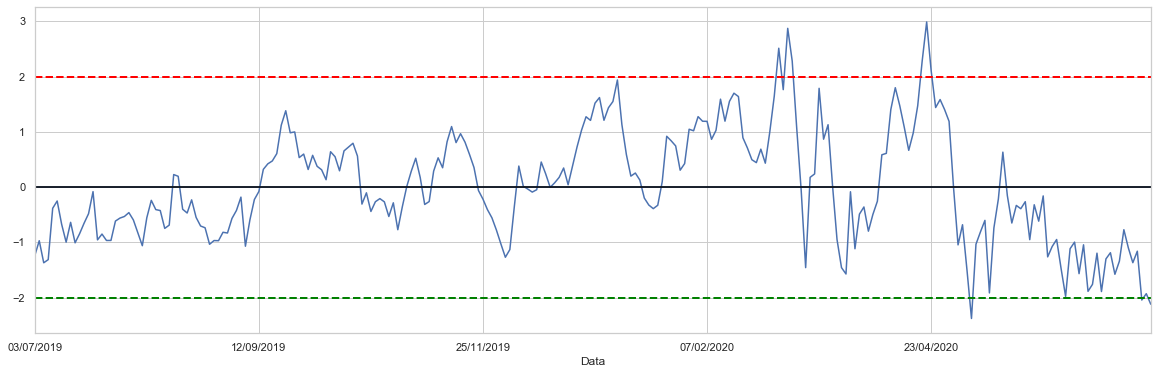

In [215]:
z_entry_threshold = 2.0
z_exit_threshold=1.0

pairs['zscore'].plot(figsize=(20, 6))
plt.axhline(pairs['zscore'].mean())
plt.axhline(0, color='black',label='mean') # Add the mean of residual
plt.axhline(z_entry_threshold, color='red', linestyle='--', linewidth=2)
plt.axhline(-z_entry_threshold, color='green', linestyle='--', linewidth=2)

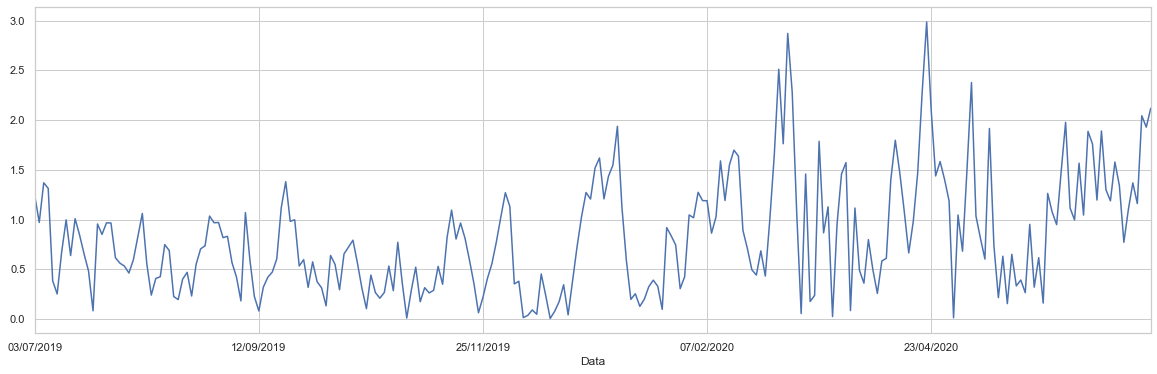

In [216]:
np.abs(pairs['zscore']).plot(figsize=(20, 6))

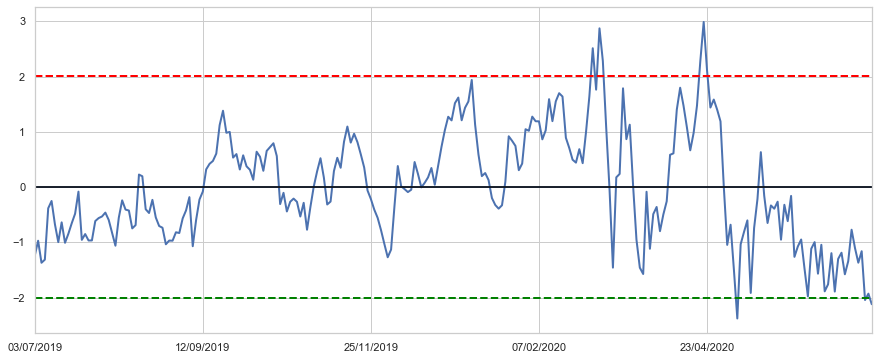

In [217]:
mult.plot_residue(pairs['zscore'][::-1])

In [234]:
def create_long_short_market_signals(pairs, symbols, z_entry_threshold=2.0, z_exit_threshold=1.0):
    # Calculate when to be long, short and when to exit
    pairs['longs'] = (pairs['zscore'] <= -z_entry_threshold)*1.0
    pairs['shorts'] = (pairs['zscore'] >= z_entry_threshold)*1.0
    pairs['exits'] = (np.abs(pairs['zscore']) <= z_exit_threshold)*1.0

    # These signals are needed because we need to propagate a
    # position forward, i.e. we need to stay long if the zscore
    # threshold is less than z_entry_threshold by still greater
    # than z_exit_threshold, and vice versa for shorts.
    pairs['long_market'] = 0.0
    pairs['short_market'] = 0.0

    # These variables track whether to be long or short while
    # iterating through the bars
    long_market = 0
    short_market = 0

    # Calculates when to actually be "in" the market, i.e. to have a
    # long or short position, as well as when not to be.
    # Since this is using iterrows to loop over a dataframe, it will
    # be significantly less efficient than a vectorised operation,
    # i.e. slow!
    print ("Calculating when to be in the market (long and short)...")
    for i, b in enumerate(pairs.iterrows()):
        # Calculate longs
        if b[1]['longs'] == 1.0:
            long_market = 1            
        # Calculate shorts
        if b[1]['shorts'] == 1.0:
            short_market = 1
        # Calculate exists
        if b[1]['exits'] == 1.0:
            long_market = 0
            short_market = 0
        # This directly assigns a 1 or 0 to the long_market/short_market
        # columns, such that the strategy knows when to actually stay in!
        pairs.ix[i]['long_market'] = long_market
        pairs.ix[i]['short_market'] = short_market
    return pairs

In [239]:
long_short_market_signals = create_long_short_market_signals(pairs, '', z_exit_threshold = 1)

Calculating when to be in the market (long and short)...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [238]:
long_short_market_signals[208:]

,ENGI11,VVAR3,spread,zscore,longs,shorts,exits,long_market,short_market
Data,,,,,,,,,
06/05/2020,41.78,10.01,-3.109779,-1.504663,0.0,0.0,0.0,0.0,0.0
07/05/2020,39.50,9.74,-4.913895,-2.377582,1.0,0.0,0.0,1.0,0.0
08/05/2020,40.82,8.85,-2.138115,-1.034524,0.0,0.0,0.0,1.0,0.0
11/05/2020,41.28,8.88,-1.676374,-0.811111,0.0,0.0,1.0,0.0,0.0
12/05/2020,41.14,8.55,-1.245661,-0.602711,0.0,0.0,1.0,0.0,0.0
13/05/2020,39.31,9.14,-3.958987,-1.915551,0.0,0.0,0.0,0.0,0.0
14/05/2020,41.50,9.02,-1.530174,-0.740373,0.0,0.0,1.0,0.0,0.0
15/05/2020,42.00,8.68,-0.443656,-0.214663,0.0,0.0,1.0,0.0,0.0
18/05/2020,44.00,8.87,1.305208,0.631523,0.0,0.0,1.0,0.0,0.0


In [240]:
def create_portfolio_returns(pairs, y_symbol, x_symbol):
    # Convenience variables for symbols
    sym1 = y_symbol
    sym2 = x_symbol

    # Construct the portfolio object with positions information
    # Note that minuses to keep track of shorts!
    portfolio = pd.DataFrame(index=pairs.index)
    portfolio['positions'] = pairs['long_market'] - pairs['short_market']
    portfolio[sym1] = -1.0 * pairs[y_symbol] * portfolio['positions']
    portfolio[sym2] = pairs[x_symbol] * portfolio['positions']
    portfolio['total'] = portfolio[sym1] + portfolio[sym2]

    # Construct a percentage returns stream and eliminate all 
    # of the NaN and -inf/+inf cells
    portfolio['returns'] = portfolio['total'].pct_change()
    portfolio['returns'].fillna(0.0, inplace=True)
    portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    portfolio['returns'].replace(-1.0, 0.0, inplace=True)

    # Calculate the full equity curve
    portfolio['returns'] = (portfolio['returns'] + 1.0).cumprod()
    return portfolio

In [241]:
create_portfolio_returns(long_short_market_signals, y_symbol, x_symbol)

,positions,ENGI11,VVAR3,total,returns
Data,,,,,
03/07/2019,0.0,-0.00,0.00,0.00,1.000000
04/07/2019,0.0,-0.00,0.00,0.00,1.000000
05/07/2019,0.0,-0.00,0.00,0.00,1.000000
08/07/2019,0.0,-0.00,0.00,0.00,1.000000
10/07/2019,0.0,-0.00,0.00,0.00,1.000000
...,...,...,...,...,...
29/06/2020,0.0,-0.00,0.00,0.00,0.925849
30/06/2020,0.0,-0.00,0.00,0.00,0.925849
01/07/2020,1.0,-48.20,15.99,-32.21,0.925849
